# 2.1. Libraries
In this section, the necessary libraries are loaded and used for the rest of the document.  We were particularly interested in nltk for text preprocessing, sklearn logistic regression, and keras for neural nets.

In [1]:
# general libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter

# nltk for text preprocessing
import nltk
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('opinion_lexicon')
nltk.download('averaged_perceptron_tagger')

# sklearn libraries
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# 3.1 Functions

# 3.1.1 Functions - Data Preprocessing
In this section several functions are built to process data and train models.  These functions are meant to keep the rest of the document clean and concise.


In [ ]:
# Function that can performs preprocessing and tokenizes text
def clean_text(text_array, extra_stop_words=False):

  # Initialize the methods
  tokenizer = nltk.tokenize.TreebankWordTokenizer()
  stop_words = stopwords.words('english')
  if extra_stop_words != False:
    stop_words.extend(extra_stop_words)
  lm = WordNetLemmatizer()

  # Tokenize the sentences into words
  words = [tokenizer.tokenize(i) for i in text_array]

  # Lowercase words
  words_lower = [[] for _ in range(len(text_array))]
  for i, observations in enumerate(words):
      for w in observations:
          words_lower[i].append(w.lower())

  # Remove punctuation
  words_alpha = [[] for _ in range(len(text_array))]
  for i, observations in enumerate(words_lower):
      for w in observations:
          if w.isalpha():
              words_alpha[i].append(w)

  # Remove common English words
  words_filtered = [[] for _ in range(len(text_array))]
  for i, observations in enumerate(words_alpha):
      for w in observations:
          if w not in stop_words:
              words_filtered[i].append(w)

  # Lemmatize words
  tag_map = defaultdict(lambda : wn.NOUN)
  tag_map['J'] = wn.ADJ
  tag_map['V'] = wn.VERB
  tag_map['R'] = wn.ADV

  words_lemm = [[] for _ in range(len(text_array))]
  for i, observations in enumerate(words_filtered):
      for w, tag in pos_tag(observations):
        words_lemm[i].append(lm.lemmatize(w, tag_map[tag[0]]))
  
  return words_lemm

# Function that counts the number of positive or negative labels per word
def label_per_word(X_train_text, y_train, feature, label, label_value):
  '''
  X_train_text = dataframe of features
  y_train = dataframe of labels
  feature = string of a particular in X_train_text
  label = string of particular label in y_train
  label_value = int representing the class
  '''
  # Tokenize, clean text, and aggregate the words
  words = clean_text(X_train_text[feature])

  # Create a dataframe: one row per observation
  words_df = pd.DataFrame({'words': words})

  # Add labels to the data frame
  words_label_df = pd.concat([words_df, y_train], axis=1, sort=True)

  # Get the words that had received or not received pizza
  temp_df = words_label_df[words_label_df[label] == label_value]

  # Count the words that were in observations that recieved pizza
  results = Counter()
  temp_df['words'].apply(results.update)
  words_per_label = pd.DataFrame.from_dict(results, orient='index', columns=['count']).sort_values(by='count', ascending=False)
  
  # Return a dataframe of words per post and words per label
  return words_df, words_per_label

# Function that downsamples majority class to fix imbalance
def down_sample_majority(df, label, majority_value):
  df_majority = df[df[label]==majority_value]
  df_minority = df[df[label]==1-majority_value]

  df_majority_downsampled = resample(df_majority, 
                                    replace=False, 
                                    n_samples=len(df_minority),
                                    random_state=1)

  df_downsampled = pd.concat([df_majority_downsampled, df_minority]).reset_index().drop(['index'], axis=1)

  shuffle = np.random.permutation(np.arange(df_downsampled.shape[0]))
  df_downsampled = df_downsampled.iloc[shuffle,].reset_index().drop(['index'], axis=1)

  return df_downsampled

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    #dfs = pd.DataFrame(columns = ['cluster', 'features', 'score'])
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tfidf.get_feature_names()
        best_features = [(label, features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['cluster', 'features', 'score'])
        #dfs = pd.concat([dfs, df])
        dfs.append(df)
 
    return dfs


# 3.1.2. Functions - Logistic Regression 

In [ ]:
# Build logistic model and search for optimal inverse regularization term
def log_reg(X_train, y_train, X_dev, y_dev, C_values):
  '''
  X_train, X_dev = array of features
  y_train, y_dev = array of labels
  C_values = list of inverse regularization term
  '''
  rmse = []
  accuracy = []
  roc = []
  for c in C_values:
      logit_pizza = LogisticRegression(penalty='l2', C=c, max_iter=1000, solver='lbfgs').fit(X_train, y_train)

      # RMSE of fit
      y_fitted = logit_pizza.predict(X_train)
      rmse.append(round(metrics.mean_squared_error(y_train, y_fitted),3))
      
      # Predict and accuracy
      y_predict = logit_pizza.predict(X_dev)
      accuracy.append(round(metrics.accuracy_score(y_dev, y_predict),3))

      # Probability and ROC_AUC_score
      prob = logit_pizza.predict_proba(X_dev)[:,1]
      roc.append(round(roc_auc_score(y_dev, prob),3))

  # Returns a list of metrics for different C_values
  return rmse, accuracy, roc

# Build logistic model for ensemble
def log_reg_to_ensemble(train, y_train, dev, C_value):
  '''
  Takes in raw values, perform feature selection as described in this notebook, and produces predictions on the dev data

  Input: raw train (dataframe), labels (dataframe), and specified C value (int)
  Output: predictions of class (0 or 1)
  '''

  # Split into num and text
  train_text = train[['request_id', 
                      'request_text_edit_aware', 
                      'request_title', 
                      'requester_subreddits_at_request', 
                      'requester_username', 
                      'unix_timestamp_of_request', 
                      'unix_timestamp_of_request_utc']]

  dev_text = dev[['request_id', 
                      'request_text_edit_aware', 
                      'request_title', 
                      'requester_subreddits_at_request', 
                      'requester_username', 
                      'unix_timestamp_of_request', 
                      'unix_timestamp_of_request_utc']]

  train_num = train[['requester_account_age_in_days_at_request',
                    'requester_days_since_first_post_on_raop_at_request', 
                    'requester_number_of_comments_at_request',
                    'requester_number_of_comments_in_raop_at_request', 
                    'requester_number_of_posts_at_request',
                    'requester_number_of_posts_on_raop_at_request', 
                    'requester_number_of_subreddits_at_request', 
                    'requester_upvotes_minus_downvotes_at_request', 
                    'requester_upvotes_plus_downvotes_at_request']]

  dev_num = dev[['requester_account_age_in_days_at_request',
                    'requester_days_since_first_post_on_raop_at_request', 
                    'requester_number_of_comments_at_request',
                    'requester_number_of_comments_in_raop_at_request', 
                    'requester_number_of_posts_at_request',
                    'requester_number_of_posts_on_raop_at_request', 
                    'requester_number_of_subreddits_at_request', 
                    'requester_upvotes_minus_downvotes_at_request', 
                    'requester_upvotes_plus_downvotes_at_request']]

  # Reset the indexes 
  train_num = train_num.reset_index().drop('index', axis=1)
  dev_num = dev_num.reset_index().drop('index', axis=1)

  train_text = train_text.reset_index().drop('index', axis=1)
  dev_text = dev_text.reset_index().drop('index', axis=1)

  y_train = pd.Series(pd.DataFrame(y_train).reset_index().drop('index', axis=1).iloc[:,0])

  # Coefficients
  logit_pizza = LogisticRegression(penalty='l2', C=C_value, max_iter=1000, solver='lbfgs').fit(train_num, y_train)
  y_predict = logit_pizza.predict(dev_num)

  coef_df = pd.DataFrame({'features': train_num.columns, 'coef': logit_pizza.coef_[0]})
  coef_df = coef_df.sort_values(by='coef', ascending=False).reset_index()
  
  # Reduce numeric features
  coef_index = list(coef_df['index'][0:4])

  train_num_red = train_num.iloc[:, coef_index]
  dev_num_red = dev_num.iloc[:, coef_index]

  # Length of posts
  train_post_length = np.array([len(i) for i in clean_train_text]).reshape(-1,1)
  dev_post_length = np.array([len(i) for i in clean_dev_text]).reshape(-1,1)

  # Scale the values
  scaler = MinMaxScaler()
  scaler.fit(train_post_length)
  train_post_length_scaled = scaler.fit_transform(train_post_length)

  scaler = MinMaxScaler()
  scaler.fit(dev_post_length)
  dev_post_length_scaled = scaler.fit_transform(dev_post_length)

  # Add to features
  train_textnum['length'] =  train_post_length_scaled
  dev_textnum['length'] = dev_post_length_scaled

  # Check if jpg is in the post
  temp_list_train = []
  for i in train_text['request_text_edit_aware']:
    if 'jpg' in i:
      temp_list_train.append(True)
    else: 
      temp_list_train.append(False)

  temp_list_dev = []
  for i in dev_text['request_text_edit_aware']:
    if 'jpg' in i:
      temp_list_dev.append(True)
    else: 
      temp_list_dev.append(False)

  # Add the feature
  train_textnum['jpg'] =  temp_list_train
  dev_textnum['jpg'] = temp_list_dev 

  # Check for time words
  time_list = ['day', 'tonight', 'month', 'time', 'hour', 'next', 'due']

  temp_list_train = []
  for i in clean_train_text:
    count = 0
    for j in time_list:
      if j in i:
        count += 1
    temp_list_train.append(count)

  temp_list_dev = []
  for i in clean_dev_text:
    count = 0
    for j in time_list:
      if j in i:
        count += 1
    temp_list_dev.append(count)

  # Scale the values
  temp_list_train = np.array(temp_list_train).reshape(-1,1)
  temp_list_dev = np.array(temp_list_dev).reshape(-1,1)

  scaler = MinMaxScaler()
  scaler.fit(temp_list_train)
  train_temp_scaled = scaler.fit_transform(temp_list_train)

  scaler = MinMaxScaler()
  scaler.fit(temp_list_dev)
  dev_temp_scaled = scaler.fit_transform(temp_list_dev)

  # Add the feature
  train_textnum['time'] =  train_temp_scaled
  dev_textnum['time'] = dev_temp_scaled
  
  logit_pizza = LogisticRegression(penalty='l2', C=C_value, max_iter=1000, solver='lbfgs').fit(train_textnum, y_train)
  y_predict_dev = logit_pizza.predict(dev_textnum)

  return y_predict_dev


# 3.1.3 Functions - Sentiment Analysis

In [ ]:
def opinion_classifier(tokenized_sentence):
    """
    Basic example of sentiment classification using Liu and Hu opinion lexicon.
    This function simply counts the number of positive, negative and neutral words
    in the sentence and classifies it depending on which polarity is more represented.
    Words that do not appear in the lexicon are considered as neutral.

    :param sentence: a sentence whose polarity has to be classified.
    :param plot: if True, plot a visual representation of the sentence polarity.
    """
    from nltk.corpus import opinion_lexicon

    pos_words = 0
    neg_words = 0

    y = []

    for word in tokenized_sentence:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1)  # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1)  # negative
        else:
            y.append(0)  # neutral

    if pos_words > neg_words:
        return 1
    elif pos_words < neg_words:
        return -1
    elif pos_words == neg_words:
        return 0 

# 4.1. EDA - Data Structure

In this section, the train, dev, and test sets are prepared for further analysis.  

Begin by importing the dataset.  The train set consists of 4040 observations or pizza request and a total of 32 variables.

In [7]:
# Load data from github
train = pd.read_json('https://raw.githubusercontent.com/sli0111/raop/main/train.json')
test = pd.read_json('https://raw.githubusercontent.com/sli0111/raop/main/train.json')

# Preview  data#
print(train.shape)
train.head(3)

(4040, 32)


,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,requester_number_of_comments_at_retrieval,requester_number_of_comments_in_raop_at_request,requester_number_of_comments_in_raop_at_retrieval,requester_number_of_posts_at_request,requester_number_of_posts_at_retrieval,requester_number_of_posts_on_raop_at_request,requester_number_of_posts_on_raop_at_retrieval,requester_number_of_subreddits_at_request,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,0,1,0,t3_l25d7,0,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,792.420405,0.0,792.420405,0,0,0,0,0,1,0,1,0,False,[],0,1,0,1,None,nickylvst,1317852607,1317849007
1,N/A,2,5,0,t3_rcb83,0,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,1122.279838,0.0,621.127072,0,1000,0,0,15,26,0,2,12,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1332652424,1332648824
2,N/A,0,3,0,t3_lpu5j,0,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.0000,771.616181,0.0,771.616181,0,0,0,0,0,1,0,1,0,False,[],0,3,0,3,None,jacquibatman7,1319650094,1319646494


Next, look for missing values in the train and test set.  We find there are missing values in 'user_flair" feature and that the test set has fewer variables than the train set.  But in further research we found a note from a researcher who collected the data:

'''
*Yes, "giver_username_if_known" cannot be used for success prediction as it perfectly indicates success (but we don't always know the giver if the request was successful).*

*Similarly, user_flair also gives away whether or not the user was successful. In fact, this is from which we derive the ground truth.*
'''

Thus, we will need to remove "giver_username_if_known" and "user_flair" features from train set and will no have missing values.  

[reference](https://www.kaggle.com/c/random-acts-of-pizza/discussion/10411)

In [ ]:
# Missing values
train.columns[train.isna().sum() != 0]

Index(['requester_user_flair'], dtype='object')

In [ ]:
test.columns[test.isna().sum() != 0]

Index([], dtype='object')

Then, compare the train and test sets to make sure they have the same features.  We find they are different and we will remove features from the train set that are not in the test set.

In [ ]:
# Some features are missing in the test set.  We will only consider the features in the test set.
train.columns.isin(test.columns)


array([ True, False, False, False,  True, False, False,  True,  True,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True,  True, False,  True,
       False, False,  True,  True,  True])

Look at the data types of each feature.  They are a mix of objects and numeric.

In [ ]:
# The features in this dataset are a mix of objects that contain text and numeric.
test_only_features = train.columns[train.columns.isin(test.columns)]

train[test_only_features].dtypes

giver_username_if_known                                object
request_id                                             object
request_text_edit_aware                                object
request_title                                          object
requester_account_age_in_days_at_request              float64
requester_days_since_first_post_on_raop_at_request    float64
requester_number_of_comments_at_request                 int64
requester_number_of_comments_in_raop_at_request         int64
requester_number_of_posts_at_request                    int64
requester_number_of_posts_on_raop_at_request            int64
requester_number_of_subreddits_at_request               int64
requester_subreddits_at_request                        object
requester_upvotes_minus_downvotes_at_request            int64
requester_upvotes_plus_downvotes_at_request             int64
requester_username                                     object
unix_timestamp_of_request                               int64
unix_tim

Split the data into numeric and text to perform EDAs on those feature types separately.

In [ ]:
# Split into num and text
train_text = train[['request_id', 
                    'request_text_edit_aware', 
                    'request_title', 
                    'requester_subreddits_at_request', 
                    'requester_username', 
                    'unix_timestamp_of_request', 
                    'unix_timestamp_of_request_utc']]

train_num = train[['requester_account_age_in_days_at_request',
                   'requester_days_since_first_post_on_raop_at_request', 
                   'requester_number_of_comments_at_request',
                   'requester_number_of_comments_in_raop_at_request', 
                   'requester_number_of_posts_at_request',
                   'requester_number_of_posts_on_raop_at_request', 
                   'requester_number_of_subreddits_at_request', 
                   'requester_upvotes_minus_downvotes_at_request', 
                   'requester_upvotes_plus_downvotes_at_request']]

labels = train['requester_received_pizza'].astype(int)

# 4.2. EDA - Numeric

Start with analysis of the metadata

First, roughly 25% of the posts received pizza.

Fraction recieved pizza: 0.246


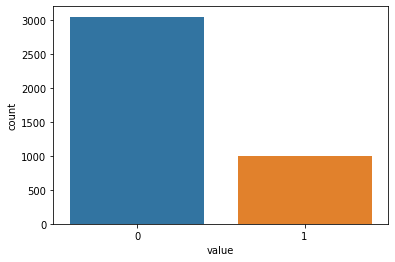

In [ ]:
# Frequency of received pizza
sns.countplot(x='value', data=pd.melt(pd.DataFrame(labels)))
a, b = np.unique(labels, return_counts=True)[1]
print('Fraction recieved pizza:', round(b/(a+b), 3))


Second, the values in the numeric features ranged quite a bit.  Some values were smaller, such as the number of days the user has had an account on reddit.  While other numbers like upvotes and downvotes were much larger.  Thus, we decided to standardize the numeric variables to to help model convergence.

In [ ]:
# Scale the values given their range varies greatly
# this will give equal weight to coefficients during gradient descent and help with convergence

names = list(train_num.columns)

scaler = MinMaxScaler()
scaler.fit(train_num)
train_num_scaled = pd.DataFrame(scaler.fit_transform(train_num), columns=train_num.columns, index=train_num.index)
train_num_scaled.head(5)

,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request
0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.001115,0.000000
1,0.178347,0.00000,0.000000,0.000000,0.017301,0.0,0.064516,0.001334,0.000090
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.001115,0.000000
3,0.002320,0.00000,0.036217,0.000000,0.001153,0.0,0.021505,0.001463,0.000059
4,0.057679,0.12936,0.140845,0.022727,0.016148,0.0,0.059140,0.008339,0.001347


Third, the numeric variables all have skewed distributions.  Some transformations like log transform could help improve relationships between the numeric variables and the labels especially for linearly separable models.  However zeros in the dataset are incompatible with log transformation so we did not pursue such transformations here.

Text(0, 0.5, 'Scaled Values')

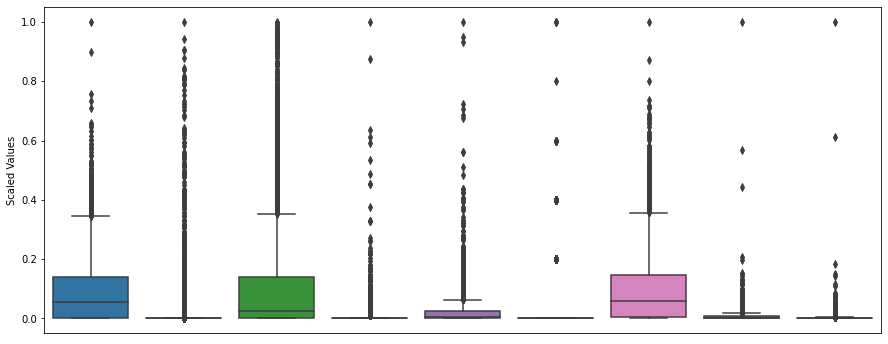

In [ ]:
# Plot boxplots of the different numeric features
dims = (15, 6)
fig, ax = plt.subplots(figsize=dims)
X_train_melt = pd.melt(train_num_scaled)

sns.boxplot(ax=ax,
            y=X_train_melt['value'], 
            x='variable', 
            data=X_train_melt)
ax.get_xaxis().set_visible(False)
ax.set_xlabel('Numeric Features')
ax.set_ylabel('Scaled Values')

Lastly, a correlation matrix is built around the numeric features.  It appears there is not numeric feature that has a strong correlation with requester_received_pizza.

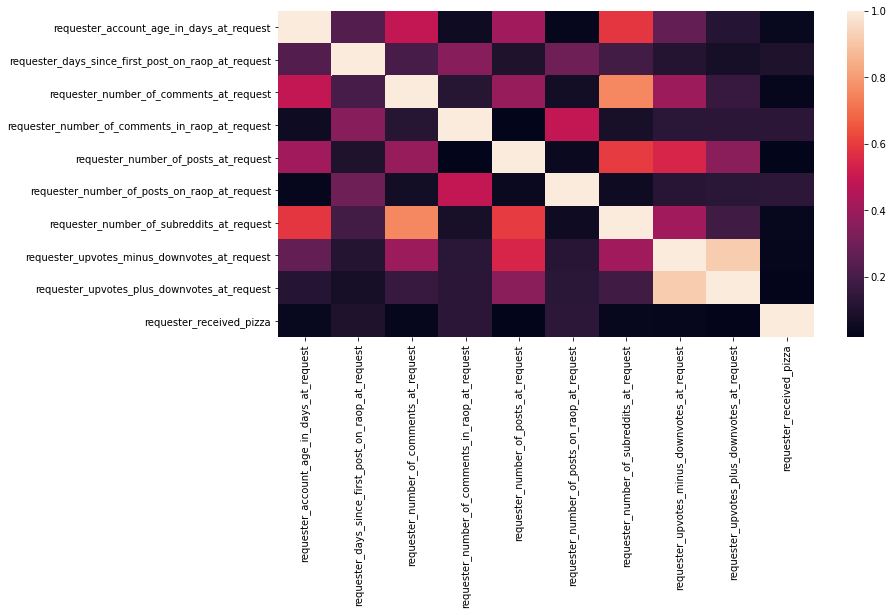

In [ ]:
# Correlation Matrix - only weak correlations b/w numeric features and label
dims = (12, 6)
fig, ax = plt.subplots(figsize=dims)

temp_df = (pd.concat([train_num_scaled, labels], axis=1, sort=False))
sns.heatmap(temp_df.corr())

# 4.3. EDA - Text

Here, the request_text is studied to find distributions of words and their relationships with requester_received_pizza.  To properly visualize the distribution of requester_recieved_pizza on text, we downsize the majority class. Otherwise the negative class will outcount the positive class.

In [ ]:
# Downsize majority with random sampling
train_down = down_sample_majority(train, 'requester_received_pizza', majority_value=0)
labels_down = train_down['requester_received_pizza']


# Split into num and text
train_text_down = train_down[['request_id', 
                    'request_text_edit_aware', 
                    'request_title', 
                    'requester_subreddits_at_request', 
                    'requester_username', 
                    'unix_timestamp_of_request', 
                    'unix_timestamp_of_request_utc']]

First, we take a look at the most popular words in both requester_received_pizza classes.  We find the most popular words are the same in both classes.

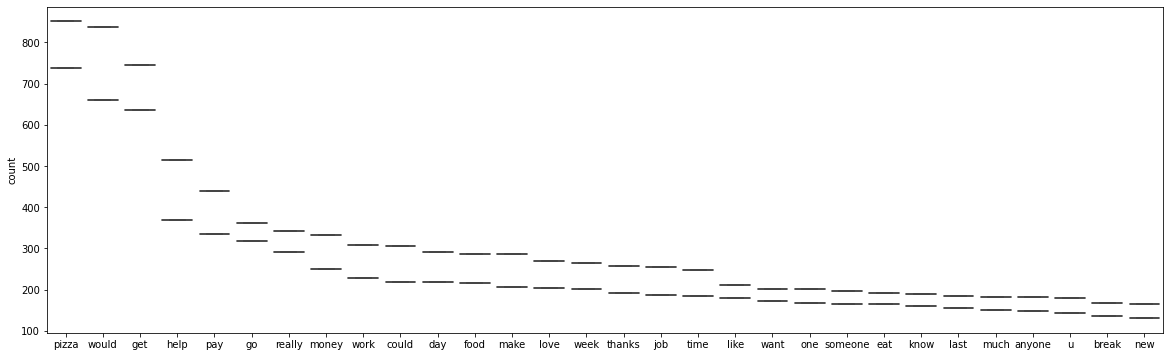

In [ ]:
# Request words vs pizza
dims = (20, 6)
fig, ax = plt.subplots(figsize=dims)

request_positive_df, request_positive_label = label_per_word(train_text_down, 
                                                         labels_down, 
                                                         feature='request_text_edit_aware', 
                                                         label='requester_received_pizza',
                                                         label_value=1)

request_negative_df, request_negative_label = label_per_word(train_text_down, 
                                                                    labels_down, 
                                                                    feature='request_text_edit_aware',
                                                                    label='requester_received_pizza',
                                                                    label_value=0)

sns.boxplot(x=request_positive_label.head(30).index, 
            y=request_positive_label.head(30)['count'])

sns.boxplot(x=request_negative_label.head(30).index, 
            y=request_negative_label.head(30)['count'])

Second, to dig deeper we use KMeans to find clusters of text data.  TfidfVectorizer is used to encode the words in each post and then PCA is used to reduce to two principal components for visualization.

Text(0.5, 1.0, 'Optimal Numer of Clusters - Elbow Method')

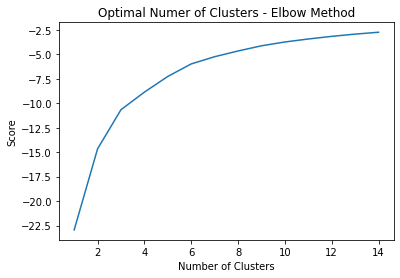

In [ ]:
# Vectorizer the words with Tfid
tfidf = TfidfVectorizer(stop_words='english', max_features=20000)
tfidf_vector = tfidf.fit_transform(train_text_down['request_text_edit_aware'])
tfidf_norm = normalize(tfidf_vector)
tfidf_array = tfidf_norm.toarray()

# Reduce to 2 principal components using PCA
pca = PCA(n_components=2)
y_pca = pca.fit_transform(tfidf_array)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm='auto')
fitted = kmeans.fit(y_pca)
prediction = kmeans.predict(y_pca)

# Search for the optimal number of clusters 
num_clusters = range(1, 15)
kmeans = [KMeans(n_clusters=i, max_iter=600) for i in num_clusters]
score = [kmeans[i].fit(y_pca).score(y_pca) for i in range(len(kmeans))]

plt.plot(num_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Optimal Numer of Clusters - Elbow Method')

Base on the above graph, six clusters is roughly chosen.

Text(0, 0.5, 'component 2')

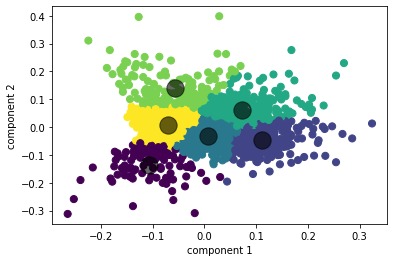

In [ ]:
# Implement kmeans for six clusters
kmeans = KMeans(n_clusters=6, max_iter=600, algorithm='auto')
fitted = kmeans.fit(y_pca)
prediction = kmeans.predict(y_pca)

# Visualize the six clusters amongst the 2 principal components
plt.scatter(y_pca[:, 0], y_pca[:, 1], c=prediction, s=50, cmap='viridis')
centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.6)
plt.xlabel('component 1')
plt.ylabel('component 2')

There is quite a bit of overlap in the clusters.  Next, the top 15 words in each cluster is visualized.

Text(0.5, 1.0, 'cluster 5')

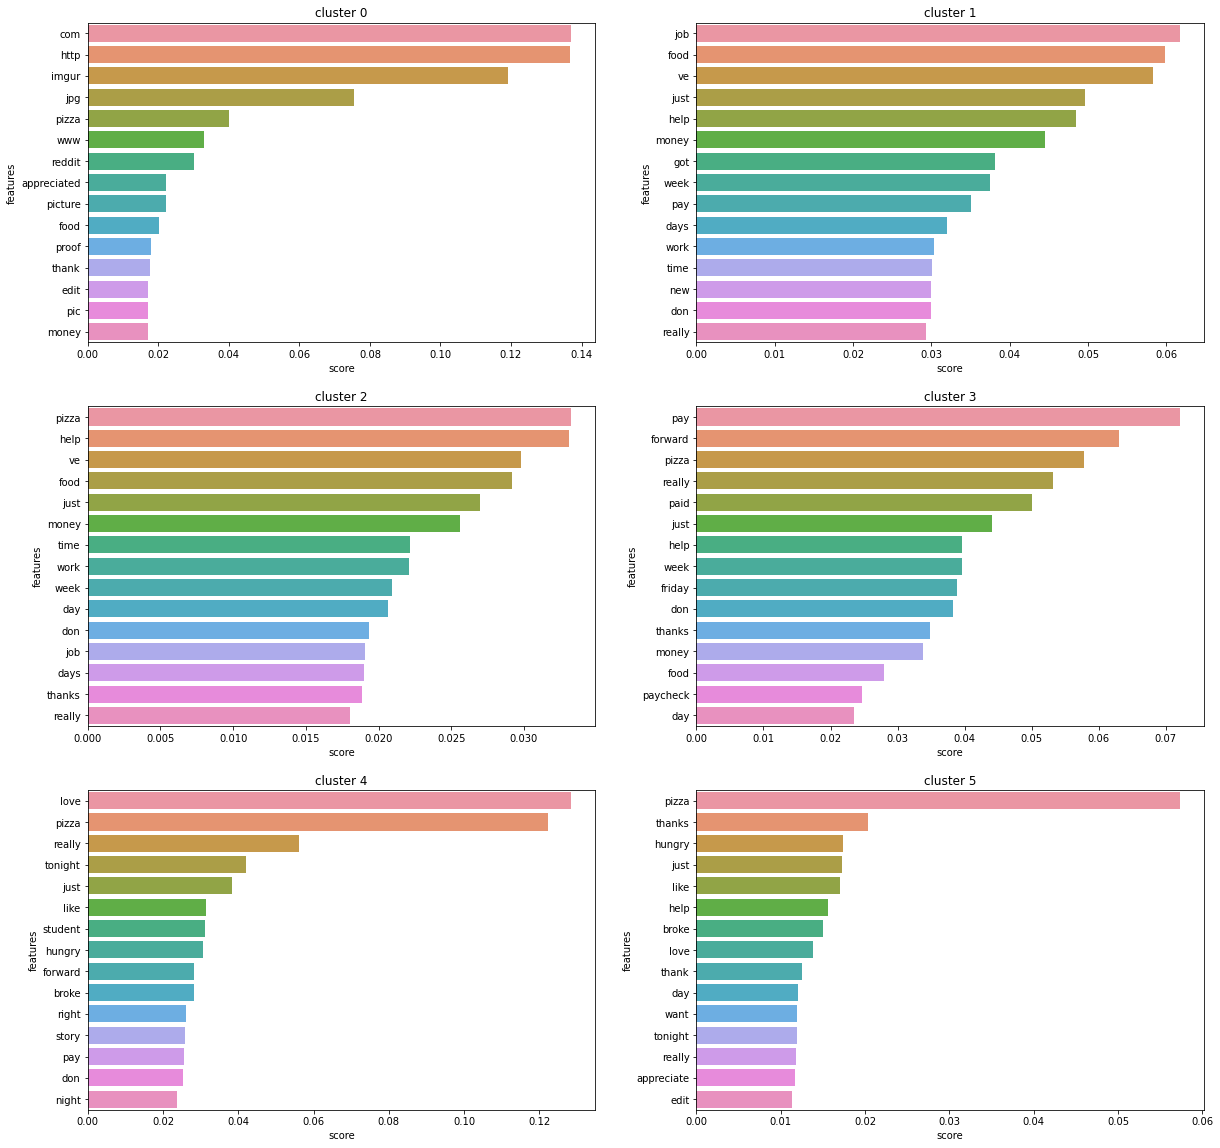

In [ ]:
dfs = get_top_features_cluster(tfidf_array, prediction, 15)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

sns.barplot(ax=ax1, x="score", y='features', orient='h', data=dfs[0]).set_title('cluster 0')
sns.barplot(ax=ax2, x="score", y='features', orient='h', data=dfs[1]).set_title('cluster 1')
sns.barplot(ax=ax3, x="score", y='features', orient='h', data=dfs[2]).set_title('cluster 2')
sns.barplot(ax=ax4, x="score", y='features', orient='h', data=dfs[3]).set_title('cluster 3')
sns.barplot(ax=ax5, x="score", y='features', orient='h', data=dfs[4]).set_title('cluster 4')
sns.barplot(ax=ax6, x="score", y='features', orient='h', data=dfs[5]).set_title('cluster 5')

The six clusters have considerable overap with words like pizza that is used in all the posts.  However the clusters suggest several categories:

Cluster 0: com, http, imgur, jpg, www, picture, proof, pic

* regards pictures and showing evidence they need pizza

Cluster 3: pay, forward

* giving back to community

Cluster 4: love

* might suggest the intensity of one's craving for pizza

Cluster 5: thanks, help, love, appreciate

* gratitude if pizza was given

Between groups:
* money: bill, pay, broke, paycheck, rent, account


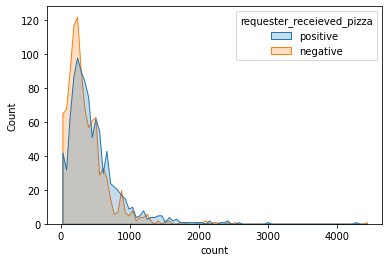

In [ ]:
length_pos_pizza = [len(i) for i in train_text_down['request_text_edit_aware'][labels_down == 1]]
length_neg_pizza = [len(i) for i in train_text_down['request_text_edit_aware'][labels_down == 0]]

temp_df1 = pd.DataFrame({'requester_receieved_pizza': 'positive', 'count':length_pos_pizza})
temp_df2 = pd.DataFrame({'requester_receieved_pizza': 'negative','count': length_neg_pizza})
temp_df3 = temp_df1.append(temp_df2)

sns.histplot(data=temp_df3, x='count', hue='requester_receieved_pizza', element="poly")

# 5.1 Train Dev Split

After EDA, we have some ideas on features to use for the models and the next step is to prepare the data by splitting the train into train and dev.

In [ ]:
# Reassembling all the features
train_features = pd.concat([train_num_scaled, train_text], axis=1)

# Split train to train and dev
X_train, X_dev, y_train, y_dev = train_test_split(train_features, labels, test_size=0.2, random_state=1)

# Split into num and text
train_text = X_train[['request_id', 
                    'request_text_edit_aware', 
                    'request_title', 
                    'requester_subreddits_at_request', 
                    'requester_username', 
                    'unix_timestamp_of_request', 
                    'unix_timestamp_of_request_utc']]

dev_text = X_dev[['request_id', 
                    'request_text_edit_aware', 
                    'request_title', 
                    'requester_subreddits_at_request', 
                    'requester_username', 
                    'unix_timestamp_of_request', 
                    'unix_timestamp_of_request_utc']]

train_num = X_train[['requester_account_age_in_days_at_request',
                   'requester_days_since_first_post_on_raop_at_request', 
                   'requester_number_of_comments_at_request',
                   'requester_number_of_comments_in_raop_at_request', 
                   'requester_number_of_posts_at_request',
                   'requester_number_of_posts_on_raop_at_request', 
                   'requester_number_of_subreddits_at_request', 
                   'requester_upvotes_minus_downvotes_at_request', 
                   'requester_upvotes_plus_downvotes_at_request']]

dev_num = X_dev[['requester_account_age_in_days_at_request',
                   'requester_days_since_first_post_on_raop_at_request', 
                   'requester_number_of_comments_at_request',
                   'requester_number_of_comments_in_raop_at_request', 
                   'requester_number_of_posts_at_request',
                   'requester_number_of_posts_on_raop_at_request', 
                   'requester_number_of_subreddits_at_request', 
                   'requester_upvotes_minus_downvotes_at_request', 
                   'requester_upvotes_plus_downvotes_at_request']]

# Reset the indexes 
train_num = train_num.reset_index().drop('index', axis=1)
dev_num = dev_num.reset_index().drop('index', axis=1)

train_text = train_text.reset_index().drop('index', axis=1)
dev_text = dev_text.reset_index().drop('index', axis=1)

y_train = pd.Series(pd.DataFrame(y_train).reset_index().drop('index', axis=1).iloc[:,0])
y_dev = pd.Series(pd.DataFrame(y_dev).reset_index().drop('index', axis=1).iloc[:,0])

print('train_num')
print(train_num.dtypes)

print('\ntrain_text')
print(train_text.dtypes)

print('\nshape')
print(train_num.shape)
print(dev_num.shape)
print(train_text.shape)
print(dev_text.shape)

train_num
requester_account_age_in_days_at_request              float64
requester_days_since_first_post_on_raop_at_request    float64
requester_number_of_comments_at_request               float64
requester_number_of_comments_in_raop_at_request       float64
requester_number_of_posts_at_request                  float64
requester_number_of_posts_on_raop_at_request          float64
requester_number_of_subreddits_at_request             float64
requester_upvotes_minus_downvotes_at_request          float64
requester_upvotes_plus_downvotes_at_request           float64
dtype: object

train_text
request_id                         object
request_text_edit_aware            object
request_title                      object
requester_subreddits_at_request    object
requester_username                 object
unix_timestamp_of_request           int64
unix_timestamp_of_request_utc       int64
dtype: object

shape
(3232, 9)
(808, 9)
(3232, 7)
(808, 7)


# 5.2 Baseline Model


# 5.2.1 Numeric features only
Now a bseline model is built using binomial logistic regression with numeric features from the training set.  The RMSE continues to decrease up to C=2 which is also the maximum of the accuracy and ROC_AUC_scores.  Based on accuracy, the score is 77% and based on ROC_AUC_score, the score is 57%.

Text(0, 0.5, 'ROC_AUC_Score')

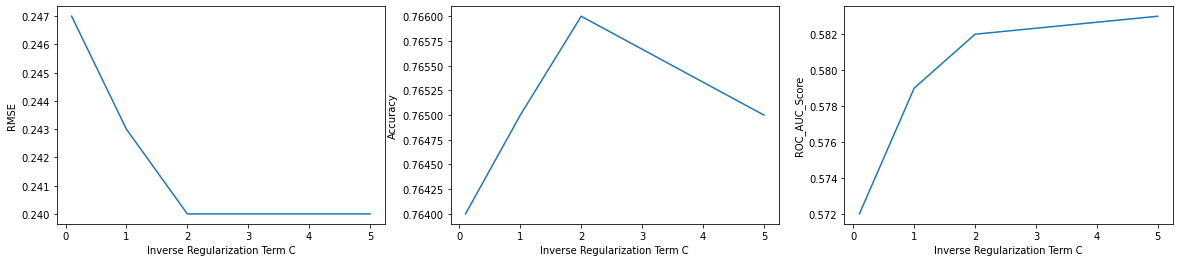

In [ ]:
# Build logistic model and search for optimal inverse regularization term
C_values = [0.1, 1, 2, 5]
rmse_base, accuracy_base, roc_base = log_reg(train_num, y_train, dev_num, y_dev, C_values=C_values)

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))

# Show both accuracy and ROC_AUC_score
ax1.plot(C_values, rmse_base, label='RMSE')
ax2.plot(C_values, accuracy_base, label='Accuracy')
ax3.plot(C_values, roc_base, label='ROC_AUC_Score')

ax1.set_xlabel('Inverse Regularization Term C')
ax1.set_ylabel('RMSE')

ax2.set_xlabel('Inverse Regularization Term C')
ax2.set_ylabel('Accuracy')

ax3.set_xlabel('Inverse Regularization Term C')
ax3.set_ylabel('ROC_AUC_Score')

# 5.2.1. Feature Engineering - Numeric

Next we take a look at the coefficients.  The magnitude of the coefficients correspond to the importance of the feature.  Additionally, a positive coefficient imparts a positive change in the probability of receiving pizza and a negative coefficient leads to decreasing chances of receiving pizza.

* Coefficient 5, 3, 1, 0 are much larger compared to the rest (given the units have been scaled)
* Since the magnitudes of the other coefficient are small, it maybe feasible to remove those features from the model

In [ ]:
# Coefficients
logit_pizza = LogisticRegression(penalty='l2', C=1, max_iter=1000, solver='lbfgs').fit(train_num, y_train)
y_predict = logit_pizza.predict(dev_num)

coef_df = pd.DataFrame({'features': train_num.columns, 'coef': logit_pizza.coef_[0]})
coef_df = coef_df.sort_values(by='coef', ascending=False).reset_index()
coef_df

,index,features,coef
0,5,requester_number_of_posts_on_raop_at_request,2.508686
1,3,requester_number_of_comments_in_raop_at_request,1.920097
2,1,requester_days_since_first_post_on_raop_at_req...,1.098080
3,0,requester_account_age_in_days_at_request,0.361794
4,6,requester_number_of_subreddits_at_request,0.262369
5,4,requester_number_of_posts_at_request,0.168050
6,7,requester_upvotes_minus_downvotes_at_request,0.087202
7,8,requester_upvotes_plus_downvotes_at_request,-0.002518
8,2,requester_number_of_comments_at_request,-0.070048


After reducing the number of coefficients, the ROC_AUC_score and the RMSE did not change much.  We were able to reduce complexity without losing performance.

In [ ]:
# Reduce the features to those of high coefficients
coef_index = list(coef_df['index'][0:4])

train_num_red = train_num.iloc[:, coef_index]
dev_num_red = dev_num.iloc[:, coef_index]

# Model on raw numeric features
rmse, accuracy, roc = log_reg(train_num, y_train, dev_num, y_dev, C_values=[1, 2])

# Model on reduced numeric features
rmse_red, accuracy_red, roc_red = log_reg(train_num_red, y_train, dev_num_red, y_dev, C_values=[1,2])

# Print results
print('RMSE - raw data: %0.2f' %rmse[1])
print('ROC_AUC_score - raw data: %0.3f' %roc[1])
print()

print('RMSE - filtered: %0.2f' %rmse_red[1])
print('ROC_AUC_score - filtered: %0.3f' %roc_red[1])

RMSE - raw data: 0.24
ROC_AUC_score - raw data: 0.582

RMSE - filtered: 0.24
ROC_AUC_score - filtered: 0.590


# 5.2.2 Feature Engineering - Text

Now we begin to add text features to the reduced numeric features.  

In [ ]:
# Clean the text data using clean_text function.
# Lower case, remove punctuation, remove common english words, and perform lemmatation
clean_train_text = clean_text(train_text['request_text_edit_aware'])
clean_dev_text = clean_text(dev_text['request_text_edit_aware'])

train_textnum = train_num_red
dev_textnum = dev_num_red

### Length of post
Recall, from the EDA that distribution of posts that received pizza was slightly right of the posts that did not, suggesting word length could be an important feature.  Below we add word length into the model and see an increase in performance.

In [ ]:
# Length of posts
train_post_length = np.array([len(i) for i in clean_train_text]).reshape(-1,1)
dev_post_length = np.array([len(i) for i in clean_dev_text]).reshape(-1,1)

# Scale the values
scaler = MinMaxScaler()
scaler.fit(train_post_length)
train_post_length_scaled = scaler.fit_transform(train_post_length)

scaler = MinMaxScaler()
scaler.fit(dev_post_length)
dev_post_length_scaled = scaler.fit_transform(dev_post_length)

# Add to features
train_textnum['length'] =  train_post_length_scaled
dev_textnum['length'] = dev_post_length_scaled

# Model on added features
rmse_length, accuracy_length, roc_length = log_reg(train_textnum, y_train, dev_textnum, y_dev, C_values=[1,2])

print('RMSE: %0.2f' %rmse_length[1])
print('ROC_AUC_score: %0.3f' %roc_length[1])

RMSE: 0.24
ROC_AUC_score: 0.604


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


### Pictures
Next, in the EDA we noticed that some post included 'http' links were to pictures.  Pictures maybe more convincing that words and so test it out as a feature.


In [ ]:
# Check if jpg is in the post
temp_list_train = []
for i in train_text['request_text_edit_aware']:
  if 'jpg' in i:
    temp_list_train.append(True)
  else: 
    temp_list_train.append(False)

temp_list_dev = []
for i in dev_text['request_text_edit_aware']:
  if 'jpg' in i:
    temp_list_dev.append(True)
  else: 
    temp_list_dev.append(False)

# Check
train_text['request_text_edit_aware'][temp_list_train].iloc[0,]

"Hi all...\n\nI've hit one of those lows. I have $1.95 in the bank and I ran out of the spaghetti I was eating once a day a couple days ago. I spent 30 minutes looking around the house for loose change and managed to find enough to get some peanut butter which is remarkably filling and has kept me relatively satisfied since. But it's running out and before I start pawning things off I thought I'd try to look for my own personal Pizza Jesus. Thank you all for the awesomeness that is RAOP.\n\n[money](http://imgur.com/LTQk5.jpg)\n\n[what I have survived on for two days](http://imgur.com/jn6Eh)\n\nNeedless to say I will contribute at my first financial opportunity.\n\nedits: spelling. because that's still important."

Adding a boolean for whether a jpg file was present in the text improves the model slightly.

In [ ]:
# Add the feature
train_textnum['jpg'] =  temp_list_train
dev_textnum['jpg'] = temp_list_dev

# Model on reduced numeric features
rmse_jpg, accuracy_jpg, roc_jpg = log_reg(train_textnum, y_train, dev_textnum, y_dev, C_values=[1,2])

print('RMSE: %0.2f' %rmse_jpg[1])
print('ROC_AUC_score: %0.3f' %roc_jpg[1])

RMSE: 0.24
ROC_AUC_score: 0.611


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Word Groups: Time

Next word groups are explored.  From the EDA it was observed references to time, gratitude, and money were common.  Counting the number of time references in a post improved the model performance slightly.

In [ ]:
# Check for time words
time_list = ['day', 'tonight', 'month', 'time', 'hour', 'next', 'due']

temp_list_train = []
for i in clean_train_text:
  count = 0
  for j in time_list:
    if j in i:
      count += 1
  temp_list_train.append(count)

temp_list_dev = []
for i in clean_dev_text:
  count = 0
  for j in time_list:
    if j in i:
      count += 1
  temp_list_dev.append(count)

In [ ]:
# Scale the values
temp_list_train = np.array(temp_list_train).reshape(-1,1)
temp_list_dev = np.array(temp_list_dev).reshape(-1,1)

scaler = MinMaxScaler()
scaler.fit(temp_list_train)
train_temp_scaled = scaler.fit_transform(temp_list_train)

scaler = MinMaxScaler()
scaler.fit(temp_list_dev)
dev_temp_scaled = scaler.fit_transform(temp_list_dev)


# Add the feature
train_textnum['time'] =  train_temp_scaled
dev_textnum['time'] = dev_temp_scaled

# Model on reduced numeric features
rmse_time, accuracy_time, roc_time = log_reg(train_textnum, y_train, dev_textnum, y_dev, C_values=[1,2])

print('RMSE: %0.2f' %rmse_time[1])
print('ROC_AUC_score: %0.3f' %roc_time[1])

RMSE: 0.24
ROC_AUC_score: 0.631


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


### Word Groups: Gratitude

Including more gratitude words, however, did not increase model performance much.

In [ ]:
# Check for gratitude words
gratitude_list = ['appreciate', 'thank', 'kind', 'give', 'please', 'love']

temp_list_train = []
for i in clean_train_text:
  count = 0
  for j in gratitude_list:
    if j in i:
      count += 1
  temp_list_train.append(count)

temp_list_dev = []
for i in clean_dev_text:
  count = 0
  for j in gratitude_list:
    if j in i:
      count += 1
  temp_list_dev.append(count)

In [ ]:
# Scale the values
temp_list_train = np.array(temp_list_train).reshape(-1,1)
temp_list_dev = np.array(temp_list_dev).reshape(-1,1)

scaler = MinMaxScaler()
scaler.fit(temp_list_train)
train_temp_scaled = scaler.fit_transform(temp_list_train)

scaler = MinMaxScaler()
scaler.fit(temp_list_dev)
dev_temp_scaled = scaler.fit_transform(temp_list_dev)

# Add the feature
train_textnum['gratitude'] =  train_temp_scaled
dev_textnum['gratitude'] = dev_temp_scaled

# Model on reduced numeric features
rmse_grat, accuracy_grat, roc_grat = log_reg(train_textnum, y_train, dev_textnum, y_dev, C_values=[1,2])

print('RMSE: %0.2f' %rmse_grat[1])
print('ROC_AUC_score: %0.3f' %roc_grat[1])

RMSE: 0.24
ROC_AUC_score: 0.631


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


### Word Groups: Money

Similary counting the number of references to money also did not.

In [ ]:
# Check for money words
money_list = ['bill', 'pay', 'broke', 'paycheck', 'rent', 'account']

temp_list_train = []
for i in clean_train_text:
  count = 0
  for j in gratitude_list:
    if j in i:
      count += 1
  temp_list_train.append(count)

temp_list_dev = []
for i in clean_dev_text:
  count = 0
  for j in gratitude_list:
    if j in i:
      count += 1
  temp_list_dev.append(count)

In [ ]:
# Scale the values
temp_list_train = np.array(temp_list_train).reshape(-1,1)
temp_list_dev = np.array(temp_list_dev).reshape(-1,1)

scaler = MinMaxScaler()
scaler.fit(temp_list_train)
train_temp_scaled = scaler.fit_transform(temp_list_train)

scaler = MinMaxScaler()
scaler.fit(temp_list_dev)
dev_temp_scaled = scaler.fit_transform(temp_list_dev)

# Add the feature
train_textnum['money'] =  train_temp_scaled
dev_textnum['money'] = dev_temp_scaled

# Model on reduced numeric features
rmse_money, accuracy_money, roc_money = log_reg(train_textnum, y_train, dev_textnum, y_dev, C_values=[1,2])

print('RMSE: %0.2f' %rmse_money[1])
print('ROC_AUC_score: %0.3f' %roc_money[1])

RMSE: 0.24
ROC_AUC_score: 0.631


### Sentimenent

Another way to look at word groups is by looking at their sentiment.  Together words may deliver a positive, negative, or neutral sentitment.  The following uses the opinion lexicon from nltk to determine a post's sentiment.  The results show that including sentiment, with this method, did not improve model performance.

In [ ]:
# Note: this may take 15-30 minutes to run
opinion_train = [opinion_classifier(i) for i in clean_train_text]
opinion_dev = [opinion_classifier(i) for i in clean_dev_text]

In [ ]:
# Add the feature
train_textnum['sentiment'] =  opinion_train
dev_textnum['sentiment'] = opinion_dev

# Model on reduced numeric features
rmse_senti, accuracy_senti, roc_senti = log_reg(train_textnum, y_train, dev_textnum, y_dev, C_values=[1,2])

print('RMSE: %0.2f' %rmse_senti[1])
print('ROC_AUC_score: %0.3f' %roc_senti[1])

RMSE: 0.24
ROC_AUC_score: 0.637


#5.2.3. Baseline model - improved

Adding features from the text data improved the ROC_AUC_Score from 58% to 63% suggesting the model is getting better at differentiating the classes.  The accuracy value did not change however, suggesting the model has no improved in predicting positive classes.

In [ ]:
models = ['baseline',
          '+reduced', 
          '+reduced, length', 
          '+reduced, length, jpg', 
          '+reduced, length, jpg, time', 
          '+reduced, length, jpg, time, gratitude',
          '+reduced, length, jpg, time, gratitude, money',
          '+reduced, length jpg, time, grattitude, money, sentiment']

models_rmse = [rmse_base[2], rmse_red[1], rmse_length[1], rmse_jpg[1], rmse_time[1], rmse_grat[1], rmse_money[1], rmse_senti[1]]
models_accuracy = [accuracy_base[2], accuracy_red[1], accuracy_length[1], accuracy_jpg[1], accuracy_time[1], accuracy_grat[1], accuracy_money[1], accuracy_senti[1]]
models_roc = [roc_base[2], roc_red[1], roc_length[1], roc_jpg[1], roc_time[1], roc_grat[1], roc_money[1], roc_senti[1]]

pd.DataFrame({'logistic models': models, 
              'rmse': models_rmse, 
              'accuracy': models_accuracy, 
              'roc': models_roc})

,logistic models,rmse,accuracy,roc
0,baseline,0.240,0.766,0.582
1,+reduced,0.241,0.766,0.590
2,"+reduced, length",0.242,0.760,0.604
3,"+reduced, length, jpg",0.243,0.759,0.611
4,"+reduced, length, jpg, time",0.242,0.762,0.631
5,"+reduced, length, jpg, time, gratitude",0.242,0.762,0.631
6,"+reduced, length, jpg, time, gratitude, money",0.242,0.762,0.631
7,"+reduced, length jpg, time, grattitude, money,...",0.243,0.762,0.637


All the features were scaled to be between 0 and 1 and thus we can compare the coefficients with one another.  

In [ ]:
# Print coefficients - units are different
logit_pizza = LogisticRegression(penalty='l2', C=1, max_iter=1000, solver='lbfgs').fit(train_textnum, y_train)
y_dev_predict = logit_pizza.predict(dev_textnum)

coef_textnum = pd.DataFrame({'features': train_textnum.columns, 'coef': logit_pizza.coef_[0]})
coef_textnum = coef_textnum.sort_values(by='coef', ascending=False)
coef_textnum

,features,coef
0,requester_number_of_posts_on_raop_at_request,2.674459
1,requester_number_of_comments_in_raop_at_request,1.915991
4,length,1.408561
6,time,1.212539
2,requester_days_since_first_post_on_raop_at_req...,1.100003
5,jpg,1.006056
3,requester_account_age_in_days_at_request,0.734841
7,gratitude,0.160612
8,money,0.160612
9,sentiment,0.045959


# 5.2.3 Error Analysis

In this section, review challenges with the model.

From the confusion matrix, we can see that the model is both low in precision and recall.  Specifically in recall, the model is predicting high on false negatives or low true positives.

In [ ]:
# Confusion Matrix
# note true positive (upper-left corner) is the number of zeros the model got correctly
print(confusion_matrix(y_dev, y_dev_predict))
print("precision: %0.3f" %metrics.precision_score(y_dev, y_dev_predict))
print("recall: %0.3f" %metrics.recall_score(y_dev, y_dev_predict))

[[601  15]
 [178  14]]
precision: 0.483
recall: 0.073


Looking at metrics plots again, the model is not overfitting.  The RMSE of the train set is low while the accuracy and ROC_AUC_scores are high.  

Text(0, 0.5, 'ROC_AUC_Score')

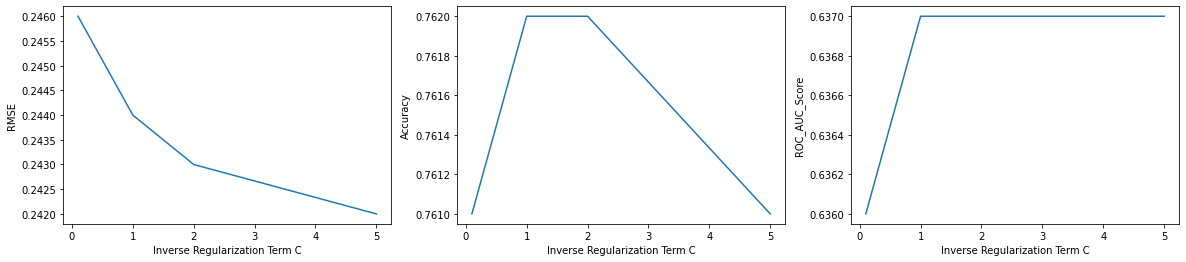

In [ ]:
# Full logistic model 
C_values = [0.1, 1, 2, 5]
rmse_full, accuracy_full, roc_full = log_reg(train_textnum, y_train, dev_textnum, y_dev, C_values=C_values)

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))

# Show both accuracy and ROC_AUC_score
ax1.plot(C_values, rmse_full, label='RMSE')
ax2.plot(C_values, accuracy_full, label='Accuracy')
ax3.plot(C_values, roc_full, label='ROC_AUC_Score')

ax1.set_xlabel('Inverse Regularization Term C')
ax1.set_ylabel('RMSE')

ax2.set_xlabel('Inverse Regularization Term C')
ax2.set_ylabel('Accuracy')

ax3.set_xlabel('Inverse Regularization Term C')
ax3.set_ylabel('ROC_AUC_Score')


The results above suggest additional features are needed given the model is not overfitting and requires more information.

# 6.1. Summary - Logistic Model

Both metadata and text data was used to build a logistic model that could predict whether a request would receive pizza.  The maximum ROC_AUC_score achieved with the model on the dev set was 63%.  Exploring both metaata and text data suggest some features impact the liklihood of receiving pizza more than others.  Specially: 

* being an active member in ROAP
* include a picture with the post
* include some reference to time
* have a lengthy post

To improve the model, we would need to add more complexity into the model.  A possible next step is to improve the word clusters.

# 7.1. Logistic Model Output


In [ ]:
# train_features excludes features in train that are not in test and 
# model excludes sentiment analysis to reduce operating time
# model includes reduced numeric features, length, pictures. time
# give_username_if_known and requester_user_flair
X_train, X_dev, y_train, labels_dev = train_test_split(train_features, labels, test_size=0.2, random_state=1)

log_reg_to_ensemble(X_train, y_train, X_dev, C_value=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,